# Competição DSA de Machine Learning - Jun/2019
# Maicon Moda

## Import Packages and Initial Settings

In [1]:
# Import packages
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import warnings

In [2]:
# Settings
path = os.getcwd()
gc.enable()
%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")
np.random.seed(2019)

In [3]:
print(os.listdir('input'))

['comerciantes.csv', 'dataset_teste.csv', 'dataset_treino.csv', 'Dicionario_de_Dados.xlsx', 'novas_transacoes_comerciantes.csv', 'sample_submission.csv', 'transacoes_historicas.csv']


In [4]:
# Logger
def get_logger():
    FORMAT = '[%(levelname)s] %(asctime)s: %(name)s: %(message)s'
    logging.basicConfig(format=FORMAT)
    logger = logging.getLogger('Main')
    logger.setLevel(logging.DEBUG)
    return logger

logger = get_logger()

## Load Data

In [5]:
logger.info('Start load data')

[INFO] 2019-06-29 22:15:29,258: Main: Start load data


In [6]:
# Read in data into a dataframe
dataset_treino = pd.read_csv('input/dataset_treino.csv')
dataset_teste = pd.read_csv('input/dataset_teste.csv')
comerciantes = pd.read_csv('input/comerciantes.csv')
novas_transacoes_comerciantes = pd.read_csv('input/novas_transacoes_comerciantes.csv')
transacoes_historicas = pd.read_csv('input/transacoes_historicas.csv')

## Exploratory Data Analysis

In [7]:
logger.info('Start exploratory data analysis')

[INFO] 2019-06-29 22:16:17,721: Main: Start exploratory data analysis


### dataset_treino.csv

In [8]:
# Show dataframe columns
print(dataset_treino.columns)

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target'],
      dtype='object')


In [9]:
# Display top of dataframe
dataset_treino.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [10]:
# Display the shape of dataframe
dataset_treino.shape

(201917, 6)

In [11]:
# See the column data types and non-missing values
dataset_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


In [12]:
# Unique values by features
dataset_treino.nunique(dropna=False, axis=0)

first_active_month        75
card_id               201917
feature_1                  5
feature_2                  3
feature_3                  2
target                197110
dtype: int64

In [13]:
# Missing values by features
dataset_treino.isnull().sum(axis=0)

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

We can see that there are:

- 1 feature type ID: card_id
- 1 feature type numerical: target
- 1 feature type date: first_active_month
- 3 features type categorical: feature_1, feature_2, feature_3

In [14]:
# Statistics of numerical features
dataset_treino[['target']].describe()

,target
count,201917.000000
mean,-0.393636
std,3.850500
min,-33.219281
25%,-0.883110
50%,-0.023437
75%,0.765453
max,17.965068


In [15]:
# Levels distribution of categorical
dataset_treino.groupby('feature_1').size()

feature_1
1    12037
2    55797
3    73573
4    19885
5    40625
dtype: int64

In [16]:
# Levels distribution of categorical
dataset_treino.groupby('feature_2').size()

feature_2
1    89242
2    74839
3    37836
dtype: int64

In [17]:
# Levels distribution of categorical
dataset_treino.groupby('feature_3').size()

feature_3
0     87719
1    114198
dtype: int64

### dataset_teste.csv

In [18]:
# Show dataframe columns
print(dataset_teste.columns)

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3'], dtype='object')


In [19]:
# Display top of dataframe
dataset_teste.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [20]:
# Display the shape of dataframe
dataset_teste.shape

(123623, 5)

In [21]:
# See the column data types and non-missing values
dataset_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
first_active_month    123622 non-null object
card_id               123623 non-null object
feature_1             123623 non-null int64
feature_2             123623 non-null int64
feature_3             123623 non-null int64
dtypes: int64(3), object(2)
memory usage: 4.7+ MB


In [22]:
# Unique values by features
dataset_teste.nunique(dropna=False, axis=0)

first_active_month        76
card_id               123623
feature_1                  5
feature_2                  3
feature_3                  2
dtype: int64

In [23]:
# Missing values by features
dataset_teste.isnull().sum(axis=0)

first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

We can see that there are:

- 1 feature type ID: card_id
- 1 feature type date: first_active_month
- 3 features type categorical: feature_1, feature_2, feature_3

In [24]:
# Levels distribution of categorical
dataset_teste.groupby('feature_1').size()

feature_1
1     7406
2    34115
3    44719
4    12332
5    25051
dtype: int64

In [25]:
# Levels distribution of categorical
dataset_teste.groupby('feature_2').size()

feature_2
1    54775
2    45993
3    22855
dtype: int64

In [26]:
# Levels distribution of categorical
dataset_teste.groupby('feature_3').size()

feature_3
0    53853
1    69770
dtype: int64

### comerciantes.csv

In [27]:
# Show dataframe columns
print(comerciantes.columns)

Index(['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'numerical_1', 'numerical_2', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4', 'city_id', 'state_id', 'category_2'],
      dtype='object')


In [28]:
# Display top of dataframe
comerciantes.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [29]:
# Display the shape of dataframe
comerciantes.shape

(334696, 22)

In [30]:
# See the column data types and non-missing values
comerciantes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
merchant_id                    334696 non-null object
merchant_group_id              334696 non-null int64
merchant_category_id           334696 non-null int64
subsector_id                   334696 non-null int64
numerical_1                    334696 non-null float64
numerical_2                    334696 non-null float64
category_1                     334696 non-null object
most_recent_sales_range        334696 non-null object
most_recent_purchases_range    334696 non-null object
avg_sales_lag3                 334683 non-null float64
avg_purchases_lag3             334696 non-null float64
active_months_lag3             334696 non-null int64
avg_sales_lag6                 334683 non-null float64
avg_purchases_lag6             334696 non-null float64
active_months_lag6             334696 non-null int64
avg_sales_lag12                334683 non-null float64
avg_purchases_lag12    

In [31]:
# Unique values by features
comerciantes.nunique(dropna=False, axis=0)

merchant_id                    334633
merchant_group_id              109391
merchant_category_id              324
subsector_id                       41
numerical_1                       954
numerical_2                       947
category_1                          2
most_recent_sales_range             5
most_recent_purchases_range         5
avg_sales_lag3                   3373
avg_purchases_lag3             100003
active_months_lag3                  3
avg_sales_lag6                   4508
avg_purchases_lag6             135202
active_months_lag6                  6
avg_sales_lag12                  5010
avg_purchases_lag12            172917
active_months_lag12                12
category_4                          2
city_id                           271
state_id                           25
category_2                          6
dtype: int64

In [32]:
# Missing values by features
comerciantes.isnull().sum(axis=0)

merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

We can see that there are:

- 6 features type ID: merchant_id, merchant_group_id, merchant_category_id, subsector_id, city_id, state_id
- 3 features type integer/counter: active_months_lag3, active_months_lag6, active_months_lag12
- 8 feature type numerical: numerical_1, numerical_2, avg_sales_lag3, avg_purchases_lag3, avg_sales_lag6, avg_purchases_lag6, avg_sales_lag12, avg_purchases_lag12
- 5 features type categorical: category_1, most_recent_sales_range, most_recent_purchases_range, category_4, category_2

In [33]:
# Statistics of numerical features
comerciantes[['active_months_lag3', 'active_months_lag6', 'active_months_lag12', 'numerical_1', 'numerical_2',
              'avg_sales_lag3', 'avg_purchases_lag3', 'avg_sales_lag6', 'avg_purchases_lag6',
              'avg_sales_lag12', 'avg_purchases_lag12']].describe()

,active_months_lag3,active_months_lag6,active_months_lag12,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,avg_sales_lag6,avg_purchases_lag6,avg_sales_lag12,avg_purchases_lag12
count,334696.000000,334696.000000,334696.000000,334696.000000,334696.000000,334683.000000,3.346960e+05,3.346830e+05,3.346960e+05,3.346830e+05,3.346960e+05
mean,2.994108,5.947397,11.599335,0.011476,0.008103,13.832993,inf,2.165079e+01,inf,2.522771e+01,inf
std,0.095247,0.394936,1.520138,1.098154,1.070497,2395.489999,NaN,3.947108e+03,NaN,5.251842e+03,NaN
min,1.000000,1.000000,1.000000,-0.057471,-0.057471,-82.130000,3.334953e-01,-8.213000e+01,1.670447e-01,-8.213000e+01,9.832954e-02
25%,3.000000,6.000000,12.000000,-0.057471,-0.057471,0.880000,9.236499e-01,8.500000e-01,9.022475e-01,8.500000e-01,8.983333e-01
50%,3.000000,6.000000,12.000000,-0.057471,-0.057471,1.000000,1.016667e+00,1.010000e+00,1.026961e+00,1.020000e+00,1.043361e+00
75%,3.000000,6.000000,12.000000,-0.047556,-0.047556,1.160000,1.146522e+00,1.230000e+00,1.215575e+00,1.290000e+00,1.266480e+00
max,3.000000,6.000000,12.000000,183.735111,182.079322,851844.640000,inf,1.513959e+06,inf,2.567408e+06,inf


In [34]:
# Levels distribution of categorical
comerciantes.groupby('category_1').size()

category_1
N    327657
Y      7039
dtype: int64

In [35]:
# Levels distribution of categorical
comerciantes.groupby('category_2').size()

category_2
1.0    160888
2.0     20661
3.0     51887
4.0     36450
5.0     52923
dtype: int64

In [36]:
# Levels distribution of categorical
comerciantes.groupby('category_4').size()

category_4
N    238596
Y     96100
dtype: int64

In [37]:
# Levels distribution of categorical
comerciantes.groupby('most_recent_sales_range').size()

most_recent_sales_range
A      1005
B      5037
C     34075
D    117475
E    177104
dtype: int64

In [38]:
# Levels distribution of categorical
comerciantes.groupby('most_recent_purchases_range').size()

most_recent_purchases_range
A      1010
B      5046
C     34144
D    119187
E    175309
dtype: int64

### novas_transacoes_comerciantes.csv

In [39]:
# Show dataframe columns
print(novas_transacoes_comerciantes.columns)

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')


In [40]:
# Display top of dataframe
novas_transacoes_comerciantes.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [41]:
# Display the shape of dataframe
novas_transacoes_comerciantes.shape

(1963031, 14)

In [42]:
# See the column data types and non-missing values
novas_transacoes_comerciantes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 209.7+ MB


In [43]:
# Unique values by features
novas_transacoes_comerciantes.nunique(dropna=False, axis=0)

authorized_flag               1
card_id                  290001
city_id                     308
category_1                    2
installments                 15
category_3                    4
merchant_category_id        314
merchant_id              226130
month_lag                     2
purchase_amount           75190
purchase_date           1667025
category_2                    6
state_id                     25
subsector_id                 41
dtype: int64

In [44]:
# Missing values by features
novas_transacoes_comerciantes.isnull().sum(axis=0)

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

We can see that there are:

- 6 features type ID: card_id, merchant_category_id, subsector_id, merchant_id, city_id, state_id
- 2 features type integer/counter: month_lag, installments
- 1 feature type numerical: purchase_amount
- 1 feature type date: purchase_date
- 4 features type categorical: authorized_flag, category_1, category_2, category_3

In [45]:
# Statistics of numerical features
novas_transacoes_comerciantes[['month_lag', 'installments', 'purchase_amount']].describe()

,month_lag,installments,purchase_amount
count,1.963031e+06,1.963031e+06,1.963031e+06
mean,1.476515e+00,6.829643e-01,-5.509690e-01
std,4.994483e-01,1.584069e+00,6.940043e-01
min,1.000000e+00,-1.000000e+00,-7.468928e-01
25%,1.000000e+00,0.000000e+00,-7.166294e-01
50%,1.000000e+00,1.000000e+00,-6.748406e-01
75%,2.000000e+00,1.000000e+00,-5.816162e-01
max,2.000000e+00,9.990000e+02,2.631575e+02


In [46]:
# Levels distribution of categorical
novas_transacoes_comerciantes.groupby('authorized_flag').size()

authorized_flag
Y    1963031
dtype: int64

In [47]:
# Levels distribution of categorical
novas_transacoes_comerciantes.groupby('category_1').size()

category_1
N    1899935
Y      63096
dtype: int64

In [48]:
# Levels distribution of categorical
novas_transacoes_comerciantes.groupby('category_2').size()

category_2
1.0    1058242
2.0      65663
3.0     289525
4.0     178590
5.0     259266
dtype: int64

In [49]:
# Levels distribution of categorical
novas_transacoes_comerciantes.groupby('category_3').size()

category_3
A    922244
B    836178
C    148687
dtype: int64

### transacoes_historicas.csv

In [50]:
# Show dataframe columns
print(transacoes_historicas.columns)

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')


In [51]:
# Display top of dataframe
transacoes_historicas.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [52]:
# Display the shape of dataframe
transacoes_historicas.shape

(29112361, 14)

In [53]:
# See the column data types and non-missing values
transacoes_historicas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB


In [54]:
# Unique values by features
transacoes_historicas.nunique(dropna=False, axis=0)

authorized_flag                2
card_id                   325540
city_id                      308
category_1                     2
installments                  15
category_3                     4
merchant_category_id         327
merchant_id               326312
month_lag                     14
purchase_amount           215014
purchase_date           16395300
category_2                     6
state_id                      25
subsector_id                  41
dtype: int64

In [55]:
# Missing values by features
transacoes_historicas.isnull().sum(axis=0)

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

We can see that there are:

- 6 features type ID: card_id, merchant_category_id, subsector_id, merchant_id, city_id, state_id
- 2 features type integer/counter: month_lag, installments
- 1 feature type numerical: purchase_amount
- 1 feature type date: purchase_date
- 4 features type categorical: authorized_flag, category_1, category_2, category_3

In [56]:
# Statistics of numerical features
transacoes_historicas[['month_lag', 'installments', 'purchase_amount']].describe()

,month_lag,installments,purchase_amount
count,2.911236e+07,2.911236e+07,2.911236e+07
mean,-4.487294e+00,6.484954e-01,3.640090e-02
std,3.588800e+00,2.795577e+00,1.123522e+03
min,-1.300000e+01,-1.000000e+00,-7.469078e-01
25%,-7.000000e+00,0.000000e+00,-7.203559e-01
50%,-4.000000e+00,0.000000e+00,-6.883495e-01
75%,-2.000000e+00,1.000000e+00,-6.032543e-01
max,0.000000e+00,9.990000e+02,6.010604e+06


In [57]:
# Levels distribution of categorical
transacoes_historicas.groupby('authorized_flag').size()

authorized_flag
N     2516909
Y    26595452
dtype: int64

In [58]:
# Levels distribution of categorical
transacoes_historicas.groupby('category_1').size()

category_1
N    27028332
Y     2084029
dtype: int64

In [59]:
# Levels distribution of categorical
transacoes_historicas.groupby('category_2').size()

category_2
1.0    15177199
2.0     1026535
3.0     3911795
4.0     2618053
5.0     3725915
dtype: int64

In [60]:
# Levels distribution of categorical
transacoes_historicas.groupby('category_3').size()

category_3
A    15411747
B    11677522
C     1844933
dtype: int64

### Exploring the connections between datasets

In [61]:
def isin(a, b):
    From = pd.DataFrame(a)
    To = pd.DataFrame(b)
    return(np.mean(From[0].isin(To[0])) * 100)

#### dataset_treino.csv with the rest

In [62]:
# % of unique credit cards from dataset_treino.csv in dataset_teste.csv
isin(dataset_treino['card_id'].unique(), dataset_teste['card_id'].unique())

0.0

In [63]:
# % of unique credit cards from dataset_treino.csv in transacoes_historicas.csv
isin(dataset_treino['card_id'].unique(), transacoes_historicas['card_id'].unique())

100.0

In [64]:
# % of unique credit cards from dataset_treino.csv in novas_transacoes_comerciantes.csv
isin(dataset_treino['card_id'].unique(), novas_transacoes_comerciantes['card_id'].unique())

89.13860645710862

#### dataset_teste.csv with the rest

In [65]:
# % of unique credit cards from dataset_teste.csv in dataset_teste.csv
isin(dataset_teste['card_id'].unique(), dataset_treino['card_id'].unique())

0.0

In [66]:
# % of unique credit cards from dataset_teste.csv in transacoes_historicas.csv
isin(dataset_teste['card_id'].unique(), transacoes_historicas['card_id'].unique())

100.0

In [67]:
# % of unique credit cards from dataset_teste.csv in novas_transacoes_comerciantes.csv
isin(dataset_teste['card_id'].unique(), novas_transacoes_comerciantes['card_id'].unique())

88.99233961317877

#### transacoes_historicas.csv with the rest

In [68]:
# % of unique credit cards from transacoes_historicas.csv in dataset_treino.csv
isin(transacoes_historicas['card_id'].unique(), dataset_treino['card_id'].unique())

62.025250353259196

In [69]:
# % of unique credit cards from transacoes_historicas.csv in dataset_teste.csv
isin(transacoes_historicas['card_id'].unique(), dataset_teste['card_id'].unique())

37.974749646740804

In [70]:
# % of unique credit cards from transacoes_historicas.csv in novas_transacoes_comerciantes.csv
isin(transacoes_historicas['card_id'].unique(), novas_transacoes_comerciantes['card_id'].unique())

89.08306198931007

In [71]:
# % of unique merchants from transacoes_historicas.csv in comerciantes.csv
isin(transacoes_historicas['merchant_id'].unique(), comerciantes['merchant_id'].unique())

99.99969354482826

#### novas_transacoes_comerciantes.csv with the rest

In [72]:
# % of unique credit cards from novas_transacoes_comerciantes.csv in dataset_treino.csv
isin(novas_transacoes_comerciantes['card_id'].unique(), dataset_treino['card_id'].unique())

62.063923917503736

In [73]:
# % of unique credit cards from novas_transacoes_comerciantes.csv in dataset_teste.csv
isin(novas_transacoes_comerciantes['card_id'].unique(), dataset_teste['card_id'].unique())

37.936076082496264

In [74]:
# % of unique credit cards from novas_transacoes_comerciantes.csv in transacoes_historicas.csv
isin(novas_transacoes_comerciantes['card_id'].unique(), transacoes_historicas['card_id'].unique())

100.0

In [75]:
# % of unique merchants from novas_transacoes_comerciantes.csv in comerciantes.csv
isin(novas_transacoes_comerciantes['merchant_id'].unique(), comerciantes['merchant_id'].unique())

99.99955777650025

#### comerciantes.csv with the rest

In [76]:
# % of unique merchants from comerciantes.csv in transacoes_historicas.csv
isin(comerciantes['merchant_id'].unique(), transacoes_historicas['merchant_id'].unique())

97.51309643699216

In [77]:
# % of unique merchants from comerciantes.csv in novas_transacoes_comerciantes.csv
isin(comerciantes['merchant_id'].unique(), novas_transacoes_comerciantes['merchant_id'].unique())

67.57522420084092

## Feature Engineering

Basically, these codes adds the merchants information to all transactions, groups all transactions information by unique credit cards, and merges it with the datasets of unique credit cards for training the model and predict the test set.

In [78]:
logger.info('Start feature engineering')

[INFO] 2019-06-29 22:17:41,689: Main: Start feature engineering


### Memory Optimization

In [79]:
# Changing datatypes to smaller formats
def reduce_memory_usage(df, verbose=True):
    numeric_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    start_memory = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numeric_types:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_memory = df.memory_usage().sum() / 1024**2
    
    print('Memory usage before optimization is: {:.2f} MB'.format(start_memory))
    print('Memory usage after optimization is: {:.2f} MB'.format(end_memory))
    print('Decreased by {:.1f} %'.format(100 * (start_memory - end_memory) / start_memory))

    return df

In [80]:
logger.info('Start memory optimization')

[INFO] 2019-06-29 22:17:41,713: Main: Start memory optimization


In [81]:
transacoes_historicas = reduce_memory_usage(transacoes_historicas)

Memory usage before optimization is: 3109.54 MB
Memory usage after optimization is: 1749.11 MB
Decreased by 43.7 %


In [82]:
novas_transacoes_comerciantes = reduce_memory_usage(novas_transacoes_comerciantes)

Memory usage before optimization is: 209.67 MB
Memory usage after optimization is: 114.20 MB
Decreased by 45.5 %


In [83]:
comerciantes = reduce_memory_usage(comerciantes)

Memory usage before optimization is: 56.18 MB
Memory usage after optimization is: 30.32 MB
Decreased by 46.0 %


In [84]:
dataset_treino = reduce_memory_usage(dataset_treino)

Memory usage before optimization is: 9.24 MB
Memory usage after optimization is: 4.04 MB
Decreased by 56.2 %


In [85]:
dataset_teste = reduce_memory_usage(dataset_teste)

Memory usage before optimization is: 4.72 MB
Memory usage after optimization is: 2.24 MB
Decreased by 52.5 %


In [86]:
gc.collect()

165

### Processing Missing Values

In [87]:
logger.info('Start processing missing values')

[INFO] 2019-06-29 22:17:45,716: Main: Start processing missing values


In [88]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [89]:
missing_values_table(transacoes_historicas)

Your selected dataframe has 14 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
category_2,2652864,9.1
category_3,178159,0.6
merchant_id,138481,0.5


In [90]:
missing_values_table(novas_transacoes_comerciantes)

Your selected dataframe has 14 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
category_2,111745,5.7
category_3,55922,2.8
merchant_id,26216,1.3


In [91]:
for df in [transacoes_historicas, novas_transacoes_comerciantes]:
    df['category_2'].fillna(1.0, inplace=True)
    df['category_3'].fillna('A', inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a', inplace=True)

In [92]:
missing_values_table(comerciantes)

Your selected dataframe has 22 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
category_2,11887,3.6
avg_sales_lag3,13,0.0
avg_sales_lag6,13,0.0
avg_sales_lag12,13,0.0


In [93]:
for df in [comerciantes]:
    df['category_2'].fillna(1.0, inplace=True)
    df['avg_sales_lag3'].fillna(df['avg_sales_lag3'].mean(), inplace=True)
    df['avg_sales_lag6'].fillna(df['avg_sales_lag6'].mean(), inplace=True)
    df['avg_sales_lag12'].fillna(df['avg_sales_lag12'].mean(), inplace=True)

In [94]:
missing_values_table(dataset_teste)

Your selected dataframe has 5 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
first_active_month,1,0.0


In [95]:
dataset_teste[dataset_teste.isnull().any(axis=1)]

,first_active_month,card_id,feature_1,feature_2,feature_3
11578,NaN,C_ID_c27b4f80f7,5,2,1


In [96]:
dataset_teste['first_active_month'].value_counts().head(5)

2017-09    8805
2017-10    8451
2017-08    8299
2017-11    7807
2017-07    7344
Name: first_active_month, dtype: int64

In [97]:
dataset_teste.loc[dataset_teste['card_id']=='C_ID_c27b4f80f7', 'first_active_month'] = "2017-09"

### Aggregation and Merge Datasets

In [98]:
logger.info('Process comerciantes')

[INFO] 2019-06-29 22:18:05,933: Main: Process comerciantes


In [99]:
comerciantes.columns = ['merch_' + str(col) for col in comerciantes.columns]

In [100]:
comerciantes.columns

Index(['merch_merchant_id', 'merch_merchant_group_id',
       'merch_merchant_category_id', 'merch_subsector_id', 'merch_numerical_1',
       'merch_numerical_2', 'merch_category_1',
       'merch_most_recent_sales_range', 'merch_most_recent_purchases_range',
       'merch_avg_sales_lag3', 'merch_avg_purchases_lag3',
       'merch_active_months_lag3', 'merch_avg_sales_lag6',
       'merch_avg_purchases_lag6', 'merch_active_months_lag6',
       'merch_avg_sales_lag12', 'merch_avg_purchases_lag12',
       'merch_active_months_lag12', 'merch_category_4', 'merch_city_id',
       'merch_state_id', 'merch_category_2'],
      dtype='object')

In [101]:
comerciantes.columns = ['merchant_id', 'merch_merchant_group_id',
       'merch_merchant_category_id', 'merch_subsector_id', 'merch_numerical_1',
       'merch_numerical_2', 'merch_category_1',
       'merch_most_recent_sales_range', 'merch_most_recent_purchases_range',
       'merch_avg_sales_lag3', 'merch_avg_purchases_lag3',
       'merch_active_months_lag3', 'merch_avg_sales_lag6',
       'merch_avg_purchases_lag6', 'merch_active_months_lag6',
       'merch_avg_sales_lag12', 'merch_avg_purchases_lag12',
       'merch_active_months_lag12', 'merch_category_4', 'merch_city_id',
       'merch_state_id', 'merch_category_2']

In [102]:
comerciantes['merch_category_1'] = comerciantes['merch_category_1'].map({'Y':1, 'N':0})
comerciantes['merch_category_4'] = comerciantes['merch_category_4'].map({'Y':1, 'N':0})
comerciantes['merch_most_recent_sales_range'] = comerciantes['merch_most_recent_sales_range'].astype('category').cat.codes
comerciantes['merch_most_recent_purchases_range'] = comerciantes['merch_most_recent_purchases_range'].astype('category').cat.codes

In [103]:
comerciantes = comerciantes.drop_duplicates(subset='merchant_id', keep="last")

In [104]:
# Merge with transacoes_historicas and novas_transacoes_comerciantes
transacoes_historicas = transacoes_historicas.merge(comerciantes, on='merchant_id', how='left')
novas_transacoes_comerciantes = novas_transacoes_comerciantes.merge(comerciantes, on='merchant_id', how='left')

In [105]:
for df in[transacoes_historicas, novas_transacoes_comerciantes]:
    del df['merch_city_id']
    del df['merch_category_2']
    del df['merch_state_id']
    del df['merch_merchant_category_id']
    del df['merch_subsector_id']
    del df['merch_category_1']

In [106]:
# Cleanup memory
del comerciantes
gc.collect()

145

In [107]:
# Define function for aggregation
def create_new_columns(name, aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [108]:
logger.info('Process transacoes_historicas and novas_transacoes_comerciantes')

[INFO] 2019-06-29 22:18:33,396: Main: Process transacoes_historicas and novas_transacoes_comerciantes


In [109]:
for df in [transacoes_historicas, novas_transacoes_comerciantes]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['category_3'] = df['category_3'].map({'A':0, 'B':1, 'C':2}) 
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [110]:
# Define aggregations with transacoes_historicas
logger.info('Aggregate transacoes_historicas')

[INFO] 2019-06-29 22:19:19,594: Main: Aggregate transacoes_historicas


In [111]:
aggs = {}

for col in ['subsector_id', 'merchant_id', 'merchant_category_id', 'state_id', 'city_id']:
    aggs[col] = ['nunique']
for col in ['month', 'hour', 'weekofyear', 'dayofweek']:
    aggs[col] = ['nunique', 'mean', 'min', 'max']

aggs['purchase_amount'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['installments'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['purchase_date'] = ['max', 'min', 'nunique']
aggs['month_lag'] = ['mean', 'min', 'max', 'var', 'nunique']
aggs['month_diff'] = ['mean', 'min', 'max', 'var', 'nunique']
aggs['authorized_flag'] = ['sum', 'mean', 'nunique']
aggs['weekend'] = ['sum', 'mean', 'nunique']
aggs['year'] = ['nunique', 'mean']
aggs['category_1'] = ['sum', 'mean', 'min', 'max', 'nunique', 'std']
aggs['category_2'] = ['sum', 'mean', 'min', 'nunique', 'std']
aggs['category_3'] = ['sum', 'mean', 'min', 'nunique', 'std']
aggs['card_id'] = ['size', 'count']

aggs['merch_numerical_1'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_numerical_2'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_most_recent_sales_range'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_most_recent_purchases_range'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_avg_purchases_lag3'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_active_months_lag3'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_avg_purchases_lag6'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_active_months_lag6'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_avg_purchases_lag12'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_active_months_lag12'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_category_4'] = ['sum', 'mean', 'min', 'nunique']

for col in ['category_2', 'category_3']:
    transacoes_historicas[col+'_mean'] = transacoes_historicas.groupby([col])['purchase_amount'].transform('mean')
    transacoes_historicas[col+'_min'] = transacoes_historicas.groupby([col])['purchase_amount'].transform('min')
    transacoes_historicas[col+'_max'] = transacoes_historicas.groupby([col])['purchase_amount'].transform('max')
    transacoes_historicas[col+'_sum'] = transacoes_historicas.groupby([col])['purchase_amount'].transform('sum')
    transacoes_historicas[col+'_std'] = transacoes_historicas.groupby([col])['purchase_amount'].transform('std')
    aggs[col+'_mean'] = ['mean']

In [112]:
# Create new colunms with transacoes_historicas
new_columns = create_new_columns('hist', aggs)
transacoes_historicas_group = transacoes_historicas.groupby('card_id').agg(aggs)
transacoes_historicas_group.columns = new_columns
transacoes_historicas_group.reset_index(drop=False, inplace=True)
transacoes_historicas_group['hist_purchase_date_diff'] = (transacoes_historicas_group['hist_purchase_date_max'] - transacoes_historicas_group['hist_purchase_date_min']).dt.days
transacoes_historicas_group['hist_purchase_date_average'] = transacoes_historicas_group['hist_purchase_date_diff'] / transacoes_historicas_group['hist_card_id_size']
transacoes_historicas_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - transacoes_historicas_group['hist_purchase_date_max']).dt.days
transacoes_historicas_group['hist_purchase_date_uptomin'] = (datetime.datetime.today() - transacoes_historicas_group['hist_purchase_date_min']).dt.days

In [113]:
# Merge with train and test datasets
dataset_treino = dataset_treino.merge(transacoes_historicas_group, on='card_id', how='left')
dataset_teste = dataset_teste.merge(transacoes_historicas_group, on='card_id', how='left')

In [114]:
# Cleanup memory
del transacoes_historicas_group
gc.collect()

70

In [115]:
# Define aggregations with novas_transacoes_comerciantes
logger.info('Aggregate novas_transacoes_comerciantes')

[INFO] 2019-06-29 22:25:01,413: Main: Aggregate novas_transacoes_comerciantes


In [116]:
aggs = {}
for col in ['subsector_id', 'merchant_id', 'merchant_category_id', 'state_id', 'city_id']:
    aggs[col] = ['nunique']
for col in ['month', 'hour', 'weekofyear', 'dayofweek']:
    aggs[col] = ['nunique', 'mean', 'min', 'max']

aggs['purchase_amount'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['installments'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['purchase_date'] = ['max', 'min', 'nunique']
aggs['month_lag'] = ['max', 'min', 'mean', 'var', 'nunique']
aggs['month_diff'] = ['mean', 'max', 'min', 'var','nunique']
aggs['weekend'] = ['sum', 'mean', 'nunique']
aggs['year'] = ['nunique', 'mean']
aggs['category_1'] = ['sum', 'mean', 'min', 'nunique']
aggs['category_2'] = ['sum', 'mean', 'min', 'nunique']
aggs['category_3'] = ['sum', 'mean', 'min', 'nunique']
aggs['card_id'] = ['size', 'count']

aggs['merch_numerical_1'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_numerical_2'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_most_recent_sales_range'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_most_recent_purchases_range'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_avg_purchases_lag3'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_active_months_lag3'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_avg_purchases_lag6'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_active_months_lag6'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_avg_purchases_lag12'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_active_months_lag12'] = ['sum', 'max', 'min', 'mean', 'var', 'std']
aggs['merch_category_4'] = ['sum', 'mean', 'min', 'nunique']

for col in ['category_2', 'category_3']:
    novas_transacoes_comerciantes[col+'_mean'] = novas_transacoes_comerciantes.groupby([col])['purchase_amount'].transform('mean')
    novas_transacoes_comerciantes[col+'_min'] = novas_transacoes_comerciantes.groupby([col])['purchase_amount'].transform('min')
    novas_transacoes_comerciantes[col+'_max'] = novas_transacoes_comerciantes.groupby([col])['purchase_amount'].transform('max')
    novas_transacoes_comerciantes[col+'_sum'] = novas_transacoes_comerciantes.groupby([col])['purchase_amount'].transform('sum')
    novas_transacoes_comerciantes[col+'_std'] = novas_transacoes_comerciantes.groupby([col])['purchase_amount'].transform('std')
    aggs[col+'_mean'] = ['mean']

In [117]:
# Create new colunms with novas_transacoes_comerciantes
new_columns = create_new_columns('new_hist', aggs)
novas_transacoes_comerciantes_group = novas_transacoes_comerciantes.groupby('card_id').agg(aggs)
novas_transacoes_comerciantes_group.columns = new_columns
novas_transacoes_comerciantes_group.reset_index(drop=False, inplace=True)
novas_transacoes_comerciantes_group['new_hist_purchase_date_diff'] = (novas_transacoes_comerciantes_group['new_hist_purchase_date_max'] - novas_transacoes_comerciantes_group['new_hist_purchase_date_min']).dt.days
novas_transacoes_comerciantes_group['new_hist_purchase_date_average'] = novas_transacoes_comerciantes_group['new_hist_purchase_date_diff'] / novas_transacoes_comerciantes_group['new_hist_card_id_size']
novas_transacoes_comerciantes_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - novas_transacoes_comerciantes_group['new_hist_purchase_date_max']).dt.days
novas_transacoes_comerciantes_group['new_hist_purchase_date_uptomin'] = (datetime.datetime.today() - novas_transacoes_comerciantes_group['new_hist_purchase_date_min']).dt.days

In [118]:
# Merge with train and test datasets
dataset_treino = dataset_treino.merge(novas_transacoes_comerciantes_group, on='card_id', how='left')
dataset_teste = dataset_teste.merge(novas_transacoes_comerciantes_group, on='card_id' ,how='left')

In [119]:
# Cleanup memory
del novas_transacoes_comerciantes_group
gc.collect()
del transacoes_historicas
gc.collect()
del novas_transacoes_comerciantes
gc.collect()

0

In [120]:
# Process train
logger.info('Outliers')

[INFO] 2019-06-29 22:25:35,192: Main: Outliers


In [121]:
dataset_treino['outliers'] = 0
dataset_treino.loc[dataset_treino['target'] < -30, 'outliers'] = 1
outls = dataset_treino['outliers'].value_counts()
print("Outliers: {}".format(outls))

Outliers: 0    199710
1      2207
Name: outliers, dtype: int64


In [122]:
# Process both train and test
logger.info('Process train and test')

[INFO] 2019-06-29 22:25:35,587: Main: Process train and test


In [123]:
for df in [dataset_treino, dataset_teste]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['dayofyear'] = df['first_active_month'].dt.dayofyear
    df['quarter'] = df['first_active_month'].dt.quarter
    df['is_month_start'] = df['first_active_month'].dt.is_month_start
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_last_buy'] = (df['new_hist_purchase_date_max'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min', 'new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size'] + df['hist_card_id_size']
    df['card_id_cnt_total'] = df['new_hist_card_id_count'] + df['hist_card_id_count']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum'] + df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_hist_purchase_amount_mean'] + df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_hist_purchase_amount_max'] + df['hist_purchase_amount_max']

for f in ['feature_1', 'feature_2', 'feature_3']:
    order_label = dataset_treino.groupby([f])['outliers'].mean()
    dataset_treino[f] = dataset_treino[f].map(order_label)
    dataset_teste[f] = dataset_teste[f].map(order_label)

## Save New Datasets

In [124]:
dataset_treino.to_csv('data/dataset_treino.csv', index=False)
dataset_teste.to_csv('data/dataset_teste.csv', index=False)

In [125]:
# Cleanup memory
del dataset_treino
gc.collect()
del dataset_teste
gc.collect()

0

## Load Data

In [126]:
# Read in data into dataframes 
X_train = pd.read_csv('data/dataset_treino.csv')
X_test = pd.read_csv('data/dataset_teste.csv')

In [132]:
X_train.shape

(201917, 300)

In [129]:
X_test.shape

(123623, 298)

In [133]:
# Separate out the features and targets
features = [c for c in X_train.columns if c not in ['card_id', 'first_active_month', 'target', 'outliers']]
target = X_train['target']
del X_train['target']

## Machine Learning

In [134]:
logger.info('Prepare model')

[INFO] 2019-06-29 22:51:56,401: Main: Prepare model


In [135]:
# Model params
param = {'num_leaves': 51,
         'min_data_in_leaf': 35, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.008,
         "boosting": "gbdt",
         "feature_fraction": 0.85,
         "bagging_freq": 1,
         "bagging_fraction": 0.82,
         "bagging_seed": 42,
         "metric": 'rmse',
         "lambda_l1": 0.11,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 2019}

In [136]:
# Prepare fit model with cross-validation
folds = StratifiedKFold(n_splits=9, shuffle=True, random_state=2019)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()

In [137]:
logger.info('Start running model')

[INFO] 2019-06-29 22:52:00,616: Main: Start running model


In [138]:
# Run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, X_train['outliers'].values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    trn_data = lgb.Dataset(X_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds=150)
    oof[val_idx] = clf.predict(X_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    # Feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # Predictions
    predictions += clf.predict(X_test[features], num_iteration=clf.best_iteration) / folds.n_splits
    logger.info(strLog)
    
strRMSE = "".format(np.sqrt(mean_squared_error(oof, target)))
print(strRMSE)

fold 0
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.55873	valid_1's rmse: 3.70001
[400]	training's rmse: 3.45164	valid_1's rmse: 3.6754
[600]	training's rmse: 3.38228	valid_1's rmse: 3.66753
[800]	training's rmse: 3.32569	valid_1's rmse: 3.66405
[1000]	training's rmse: 3.27686	valid_1's rmse: 3.66319
[1200]	training's rmse: 3.23261	valid_1's rmse: 3.66194
[1400]	training's rmse: 3.193	valid_1's rmse: 3.6622
Early stopping, best iteration is:
[1292]	training's rmse: 3.21415	valid_1's rmse: 3.66179


[INFO] 2019-06-29 22:53:56,058: Main: fold 0


fold 1
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.55862	valid_1's rmse: 3.69184
[400]	training's rmse: 3.45075	valid_1's rmse: 3.67087
[600]	training's rmse: 3.38042	valid_1's rmse: 3.66376
[800]	training's rmse: 3.32361	valid_1's rmse: 3.66092
[1000]	training's rmse: 3.27443	valid_1's rmse: 3.65935
Early stopping, best iteration is:
[974]	training's rmse: 3.2806	valid_1's rmse: 3.65898


[INFO] 2019-06-29 22:55:38,501: Main: fold 1


fold 2
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.55899	valid_1's rmse: 3.69665
[400]	training's rmse: 3.4516	valid_1's rmse: 3.67602
[600]	training's rmse: 3.38087	valid_1's rmse: 3.66725
[800]	training's rmse: 3.32579	valid_1's rmse: 3.66318
[1000]	training's rmse: 3.27687	valid_1's rmse: 3.66013
[1200]	training's rmse: 3.23286	valid_1's rmse: 3.65893
[1400]	training's rmse: 3.19283	valid_1's rmse: 3.65768
[1600]	training's rmse: 3.15525	valid_1's rmse: 3.6572
Early stopping, best iteration is:
[1523]	training's rmse: 3.16963	valid_1's rmse: 3.65707


[INFO] 2019-06-29 22:57:53,545: Main: fold 2


fold 3
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.56167	valid_1's rmse: 3.66705
[400]	training's rmse: 3.45194	valid_1's rmse: 3.64504
[600]	training's rmse: 3.38246	valid_1's rmse: 3.638
[800]	training's rmse: 3.32664	valid_1's rmse: 3.63378
[1000]	training's rmse: 3.27791	valid_1's rmse: 3.63133
[1200]	training's rmse: 3.23311	valid_1's rmse: 3.62926
[1400]	training's rmse: 3.19295	valid_1's rmse: 3.62866
[1600]	training's rmse: 3.15453	valid_1's rmse: 3.62793
[1800]	training's rmse: 3.11913	valid_1's rmse: 3.62802
Early stopping, best iteration is:
[1669]	training's rmse: 3.14195	valid_1's rmse: 3.62774


[INFO] 2019-06-29 23:00:12,826: Main: fold 3


fold 4
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.55966	valid_1's rmse: 3.68631
[400]	training's rmse: 3.44944	valid_1's rmse: 3.66435
[600]	training's rmse: 3.37819	valid_1's rmse: 3.65829
[800]	training's rmse: 3.32194	valid_1's rmse: 3.65535
[1000]	training's rmse: 3.27253	valid_1's rmse: 3.65556
Early stopping, best iteration is:
[870]	training's rmse: 3.30435	valid_1's rmse: 3.65508


[INFO] 2019-06-29 23:01:38,934: Main: fold 4


fold 5
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.55469	valid_1's rmse: 3.70866
[400]	training's rmse: 3.44567	valid_1's rmse: 3.69386
[600]	training's rmse: 3.3744	valid_1's rmse: 3.68823
[800]	training's rmse: 3.31776	valid_1's rmse: 3.6857
Early stopping, best iteration is:
[835]	training's rmse: 3.30901	valid_1's rmse: 3.68528


[INFO] 2019-06-29 23:03:04,417: Main: fold 5


fold 6
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.55927	valid_1's rmse: 3.69213
[400]	training's rmse: 3.45181	valid_1's rmse: 3.67092
[600]	training's rmse: 3.38116	valid_1's rmse: 3.66314
[800]	training's rmse: 3.3234	valid_1's rmse: 3.66012
[1000]	training's rmse: 3.27413	valid_1's rmse: 3.65937
Early stopping, best iteration is:
[983]	training's rmse: 3.2781	valid_1's rmse: 3.65911


[INFO] 2019-06-29 23:04:39,967: Main: fold 6


fold 7
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.55682	valid_1's rmse: 3.70127
[400]	training's rmse: 3.44938	valid_1's rmse: 3.68668
[600]	training's rmse: 3.3789	valid_1's rmse: 3.67864
[800]	training's rmse: 3.32253	valid_1's rmse: 3.67655
[1000]	training's rmse: 3.27263	valid_1's rmse: 3.67459
[1200]	training's rmse: 3.22897	valid_1's rmse: 3.67429
Early stopping, best iteration is:
[1108]	training's rmse: 3.24857	valid_1's rmse: 3.67399


[INFO] 2019-06-29 23:06:27,589: Main: fold 7


fold 8
Training until validation scores don't improve for 150 rounds.
[200]	training's rmse: 3.56257	valid_1's rmse: 3.67351
[400]	training's rmse: 3.45562	valid_1's rmse: 3.65151
[600]	training's rmse: 3.38398	valid_1's rmse: 3.64463
Early stopping, best iteration is:
[642]	training's rmse: 3.37095	valid_1's rmse: 3.64383


[INFO] 2019-06-29 23:07:38,132: Main: fold 8


In [139]:
logger.info("Feature importance plot")

[INFO] 2019-06-29 23:07:38,148: Main: Feature importance plot


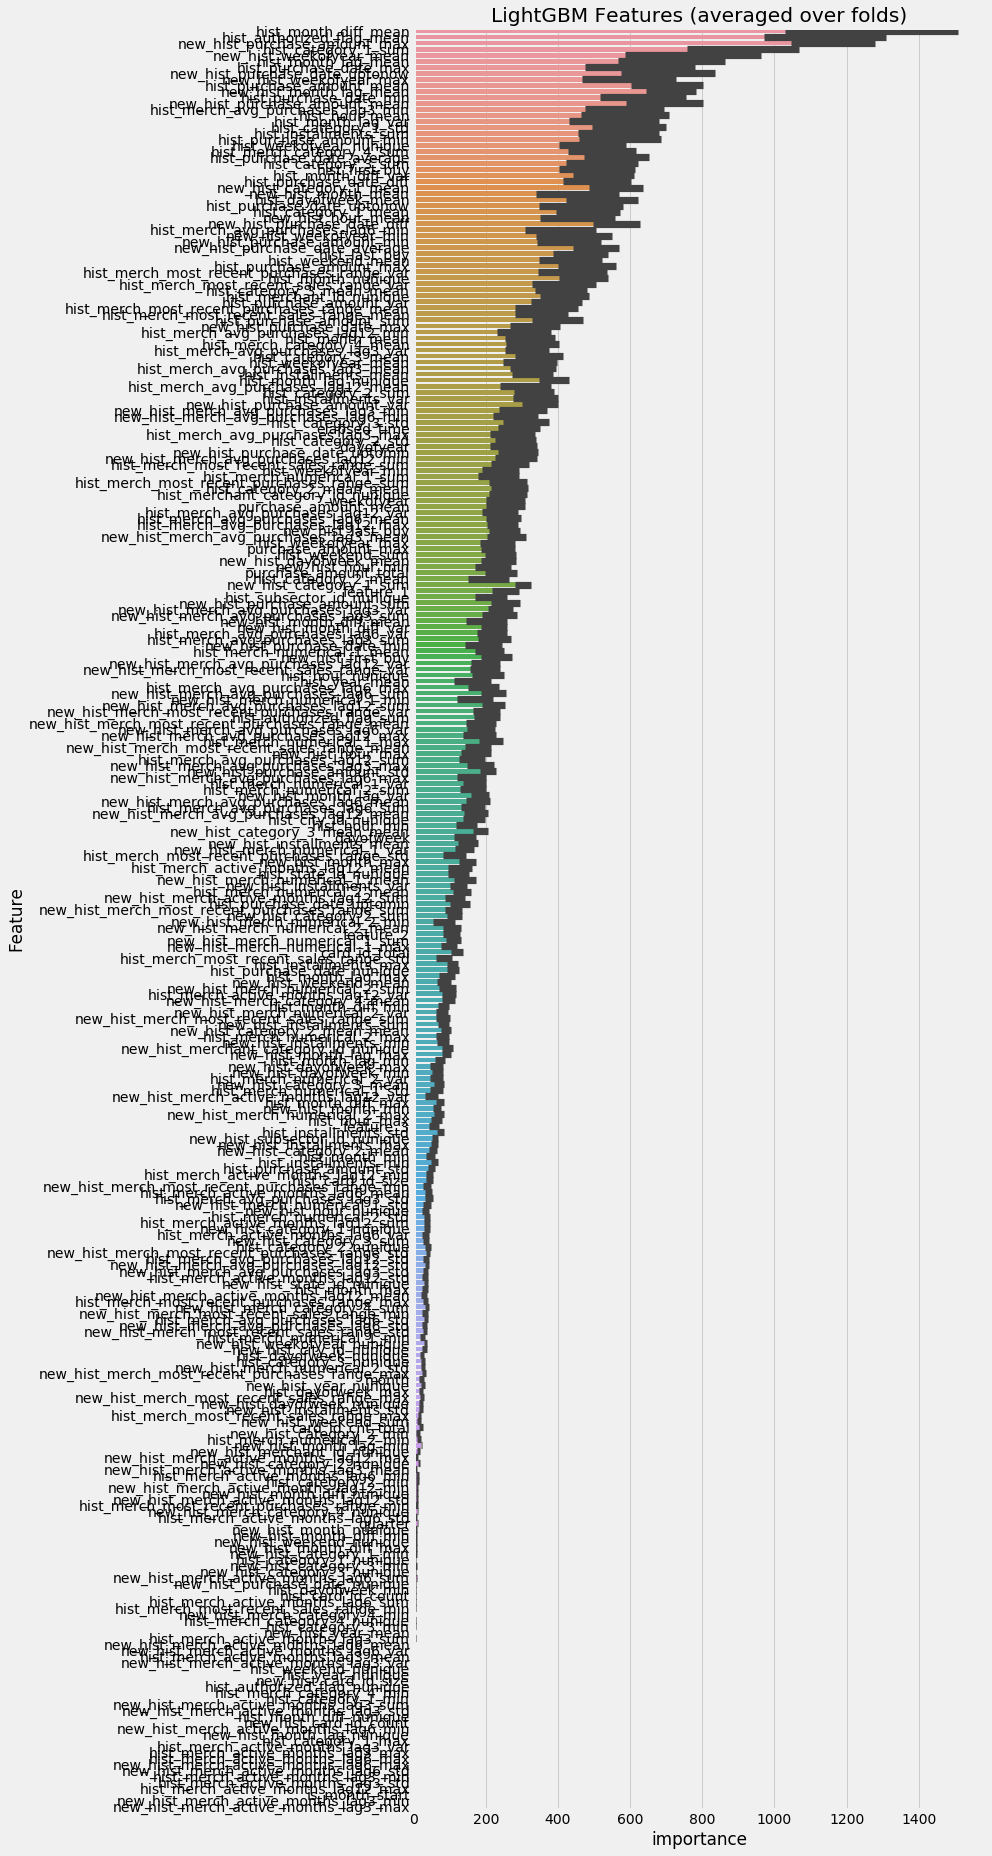

In [140]:
# Plot the feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')
plt.show()

## Submission

In [141]:
logger.info("Prepare submission")

[INFO] 2019-06-29 23:07:48,770: Main: Prepare submission


In [142]:
# Submission
submission = pd.DataFrame({"card_id":X_test["card_id"].values})
submission["target"] = predictions
submission.to_csv("submission.csv", index=False)

In [143]:
submission.head(20)

,card_id,target
0,C_ID_0ab67a22ab,-2.995384
1,C_ID_130fd0cbdd,-0.264715
2,C_ID_b709037bc5,-0.892152
3,C_ID_d27d835a9f,-0.148079
4,C_ID_2b5e3df5c2,-1.219302
5,C_ID_5814b4f13c,0.004214
6,C_ID_a1b3c75277,0.005808
7,C_ID_f7cada36d3,0.555631
8,C_ID_9d2bc8dfc4,-0.806123
9,C_ID_6d8dba8475,-0.892889


## End